## Transformer
本教程演示如何创建和训练一个序列到序列（seq2seq）的Transformer模型来将葡萄牙语翻译成英语。Transformer最初是由Vaswani等人(2017)在“Attention is All You Need”一文中提出的。

Transformer是一种深度神经网络，它用自我关注取代了CNNs和RNNs。自关注使Transformer能够轻松地跨输入序列传输信息。

正如谷歌人工智能博客中所解释的那样： 

用于机器翻译的神经网络通常包含一个编码器，它读取输入的句子并生成它的表示。然后，解码器在参考编码器生成的表示时，一个单词一个单词地生成输出句子。Transformer首先为每个单词生成初始表示或嵌入……然后，利用自我注意，它从所有其他单词中收集信息，根据整个上下文生成每个单词的新表示，由填充的球表示。然后对所有单词并行重复此步骤多次，依次生成新的表示。

这里很多理解，本教程的目标是将其分解成易于理解的部分。在本教程中，你将:
* 准备数据
* 实施必要的组件
  * 位置嵌入
  * 注意力层
  * 编码器和解码器
* 构造和训练Transformer
* 生成翻译
* 导出模型

为了充分利用本教程，了解文本生成和注意力机制的基础知识会有所帮助。

Transformer是一种序列到序列的编码器-解码器模型，类似于NMT with attention教程中的模型。单层Transformer需要编写更多的代码，但几乎与编码器-解码器RNN模型相同。唯一的区别是RNN层被自关注层所取代。本教程构建了一个更大更强大的4层Transformer，但从根本上来说并不更复杂。

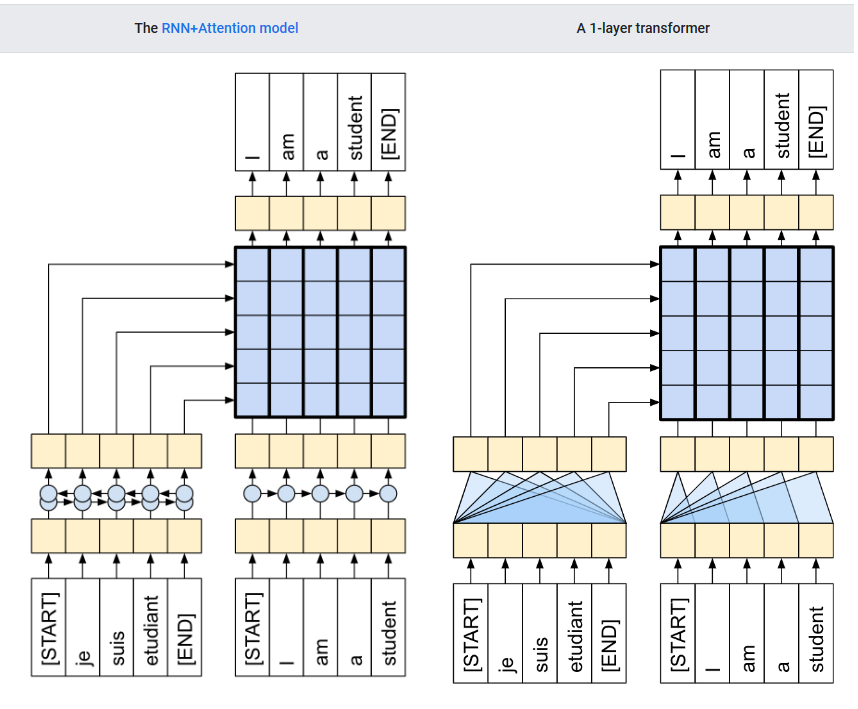

训练本笔记本中的模型后，您将能够输入葡萄牙语句子并返回英语翻译。

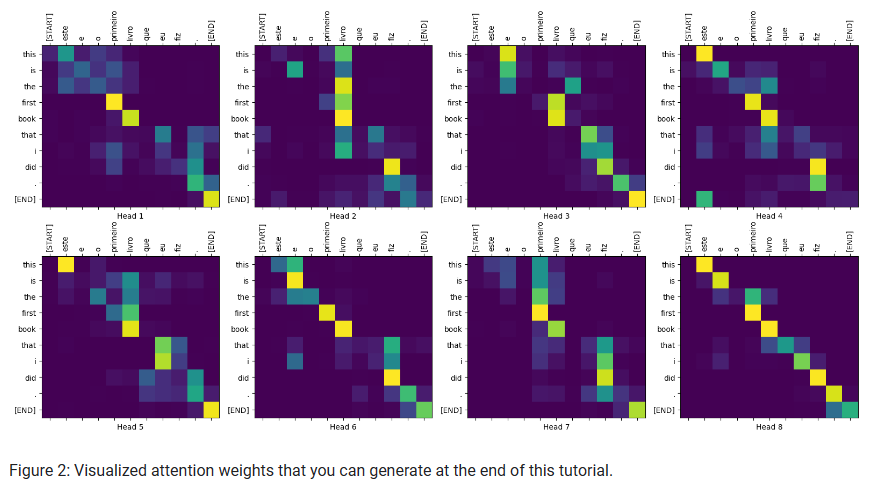

图2.你可以在本教程的最后生成可视化的注意力权重。

### 为什么Transformer很重要
* Transformer擅长对顺序数据建模，比如自然语言。
* 与循环神经网络(RNNs)不同，Transformer是可并行的。这使得它们在GPU和TPU等硬件上效率很高。主要原因是Transformer用注意代替了递归，计算可以同时进行。层输出可以并行计算，而不是像RNN那样串行计算。
* 与RNN(如seq2seq, 2014)或卷积神经网络(CNN)(例如ByteNet)不同，transformer能够捕获输入或输出序列中遥远位置之间的数据中的远程上下文和依赖关系。因此，可以学习较长的连接。注意允许每个位置访问每一层的整个输入，而在RNN和CNN中，信息需要经过许多处理步骤才能移动很长一段距离，这使得学习变得更加困难。
* Transformer不假设数据之间的时间/空间关系。这对于处理一组对象(例如《星际争霸》单位)来说是非常理想的。

图3.经过英法翻译训练的Transformer的第5层到第6层(八个注意头之一)的单词“it”的编码器自注意分布。

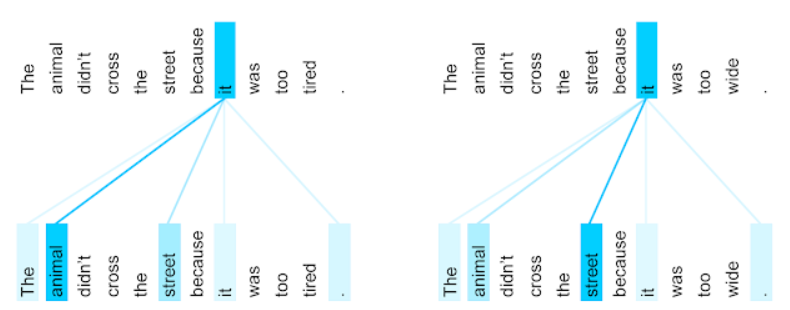

In [1]:
# 安装
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
#!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
#!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
#!pip install protobuf~=3.20.3
#!pip install -q tensorflow_datasets
#!pip install -q -U tensorflow-text tensorflow
#!pip install  tensorflow-gpu

In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

import os
from tensorflow.python.client import device_lib

In [3]:
# 查看GPU是否存在
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [4]:
#查看CPU和GPU
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(gpus, cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### 数据处理
本节从本教程下载数据集和子词标记器，然后将其全部打包到tf.data.Dataset中进行训练。

#### 下载数据集
使用TensorFlow数据集加载葡萄牙语-英语翻译数据集。该数据集包含大约52,000个训练样本，1,200个验证样本和1,800个测试样本。

In [5]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                 with_info=True,
                 as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

TensorFlow数据集返回的tf.data.Dataset对象产生一对文本示例:

In [6]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> 葡萄牙语例句:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> 英语例句:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> 葡萄牙语例句:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> 英语例句:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


#### 设置分词器
现在已经加载了数据集，需要对文本进行标记，以便将每个元素表示为token或token ID(数字表示)。



分词化是将文本分解成“tokens”的过程。根据分词器的不同，这些tokens可以表示句子片段、单词、子单词或字符。要了解有关标记化的更多信息。

使用子词分词器教程中内置的分词器。该教程优化了两个文本。这个数据集的BertTokenizer对象(一个用于英语，一个用于葡萄牙语)，并以TensorFlow saved_model格式导出它们。

下载、提取并导入saved_model:

In [7]:
model_name = 'ted_hrlr_translate_pt_en_converter.zip'
#tf.keras.utils.get_file(
#    f'{model_name}.zip',
#    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
#    cache_dir='.', cache_subdir='', extract=True
#)


In [8]:
model_dir='D:\\Github_code\\TensorFlow-note\\NLP\\ted_hrlr_translate_pt_en_converter'
tokenizers = tf.saved_model.load(model_dir)

saved_model包含两个文本分词器，一个用于英语，一个用于葡萄牙语。两者都有相同的方法:

In [9]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

tokenize方法将一批字符串转换为一批填充的tokenIDs。此方法将标点符号、小写字母分开，并在分词之前对输入进行unicode规范化。由于输入数据已经标准化，因此在这里看不到标准化。

In [10]:
print('> 这是一批字符串:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> 这是一批字符串:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [11]:
encoded = tokenizers.en.tokenize(en_examples)

print('> 这是一个填充批次 token IDs:')
for row in encoded.to_list():
  print(row)

> 这是一个填充批次 token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


detokenize方法试图将这些tokenIDs转换回人类可读的文本:

In [12]:
round_trip = tokenizers.en.detokenize(encoded)

print('> 这是人类可读的文本:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> 这是人类可读的文本:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


降级lookup方法将从tokenIDs转换为token文本:

In [13]:
print('> 这是被分割成符号的文本:')
tokens = tokenizers.en.lookup(encoded)
tokens

> 这是被分割成符号的文本:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

输出演示了子词分词器的“子词”层面。

例如，单词“searchability”被分解为“search”和“##ability”，单词“serendipity”被分解为“s”、“##ere”、“##nd”、“##ip”和“##ity”。

请注意，分词化的文本包括'[START]'和'[END]'标记。

数据集中每个示例的tokens分布如下:

In [14]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

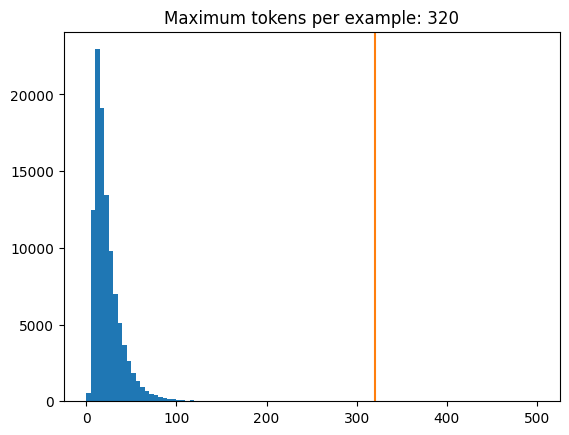

In [15]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');# 每个示例最大的单词数

#### 使用tf.data设置数据流水线
下面的函数将批量文本作为输入，并将其转换为适合训练的格式。
* 它把它们分成几批。
* 它将每个值裁剪为不超过MAX_TOKENS。
* 它将目标(英语)tokens分成输入和标签。它们被移动一步，因此在每个输入位置，标签是下一个token的id。
* 它将RaggedTesor转换为填充稠密张量。
* 它返回一个(inputs, labels)对。

In [16]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # 输出是不对齐的.
    pt = pt[:, :MAX_TOKENS]    # 修改为MAX_TOKENS.
    pt = pt.to_tensor()  # 转换为0填充密集张量

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # 删除[END] token（单词）
    en_labels = en[:, 1:].to_tensor()   # 删除[START] token

    return (pt, en_inputs), en_labels

下面的函数将文本示例的数据集转换为用于训练的批量数据。
* 它对文本进行分词，并过滤掉太长的序列。(包括批处理/取消批处理，因为分词器在大批量处理时效率更高)。
* 缓存方法确保该工作只执行一次。
* 然后shuffle和dense_to_ragged_batch随机化顺序并组装批次的示例。
* 最后prefetch与模型并行运行数据集，以确保数据在需要时可用。查看更好的性能用tf.data

In [17]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [18]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

### 测试数据集


In [19]:
# 创建训练和验证集批次。
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

生成的tf.data.Dataset对象被设置为使用Keras进行训练。Keras模型。适合训练期望(输入，标签)对。输入是对tokens的葡萄牙语和英语序列(pt, en)。标签是相同的英文序列，移动了1。这种移位是为了在每个位置按顺序输入，下一个token中的标签。
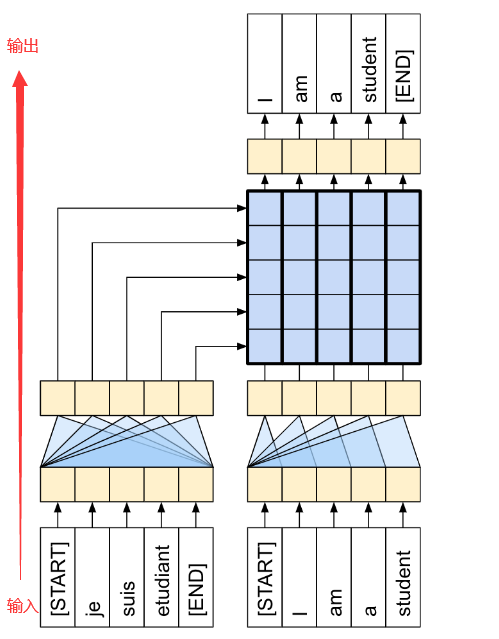

这与文本生成教程相同，除了这里您有额外的输入“上下文”(葡萄牙语序列)，模型是“受约束”的。

这种设置被称为“teacher forcing”（导师监督），因为无论模型在每个时间步长的输出如何，它都会将真实值作为下一个时间步的输入。这是一种简单而有效的训练文本生成模型的方法。它是高效的，因为您不需要按顺序运行模型，不同序列位置的输出可以并行计算。

您可能期望输入、输出、对仅仅是葡萄牙语、英语序列。给定葡萄牙语序列，该模型将尝试生成英语序列。

用这种方法训练模型是可能的。您需要写出推理循环，并将模型的输出传递回输入。它更慢(时间步不能并行运行)，而且更难学习(模型在得到正确的开头之前不能得到正确的句子结尾)，但它可以提供一个更稳定的模型，因为模型必须在训练过程中学习纠正自己的错误。

In [20]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 85)
(64, 80)
(64, 80)


en和en_labels是一样的，只是移动了1:

In [21]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([  2  36  36   9  79 158 114  73  57 459], shape=(10,), dtype=int64)
tf.Tensor([ 36  36   9  79 158 114  73  57 459  15], shape=(10,), dtype=int64)


### 定义组件
Transformer里面发生了很多事。重要的是要记住:
* 它遵循与具有编码器和解码器的标准序列到序列模型相同的一般模式。
* 如果你一步一步来，就会明白了。

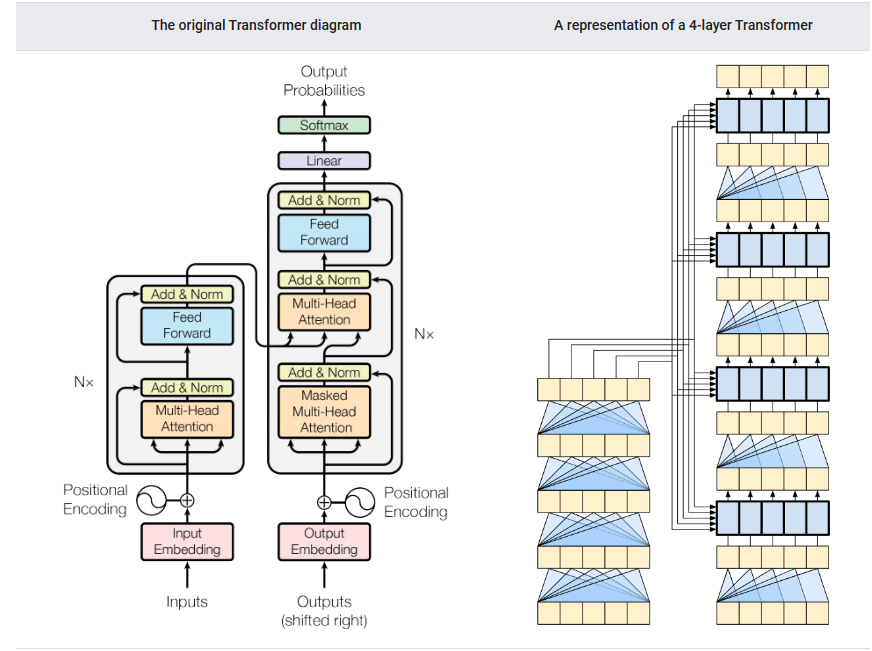

这两个图中的每个组件都将在之后教程的过程中进行解释。

#### 嵌入和位置编码
编码器和解码器的输入都使用相同的嵌入和位置编码逻辑。  
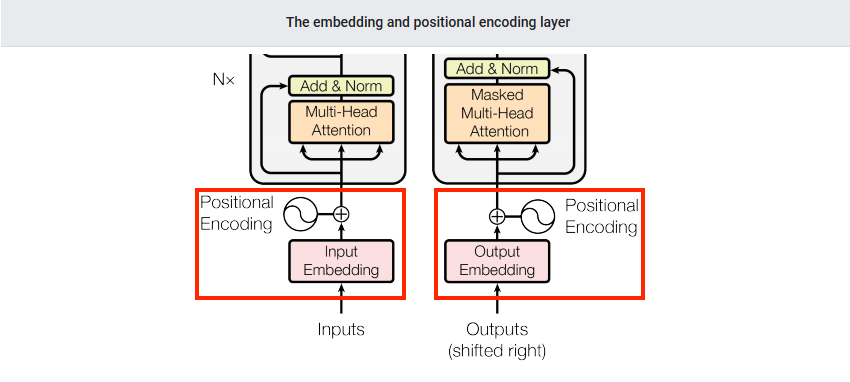

给定一个tokens序列，输入tokens(葡萄牙语)和目标tokens(英语)都必须使用tf.keras.layers.Embedding层转换为向量。

整个模型中使用的注意力层将它们的输入视为一组没有顺序的向量。因为模型不包含任何循环层或卷积层。它需要某种方法来识别词序，否则它会将输入序列视为一袋单词实例，how are you, how you are, you how are，等等，都是无法区分的。

Transformer将“位置编码”添加到嵌入向量中。它使用一组不同频率的正弦和余弦(在整个序列中)。根据定义，附近的元素将具有类似的位置编码。

计算位置编码的公式(下面用Python实现)如下:



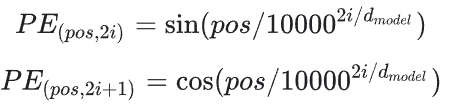

In [22]:
# 位置编码
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

位置编码函数是正弦和余弦的堆栈，根据它们在嵌入向量的深度上的位置以不同的频率振动。它们沿着位置轴振动。

(2048, 512)


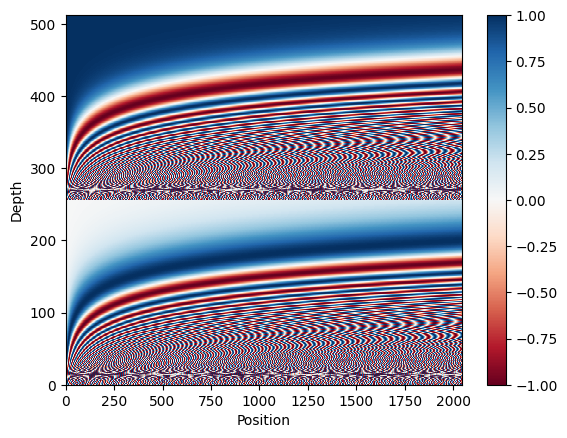

In [23]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

根据定义，这些向量沿着位置轴与附近的向量对齐。下面的位置编码向量被归一化，并且位置1000的向量通过点积与所有其他向量进行比较:

(0.0, 1.0)

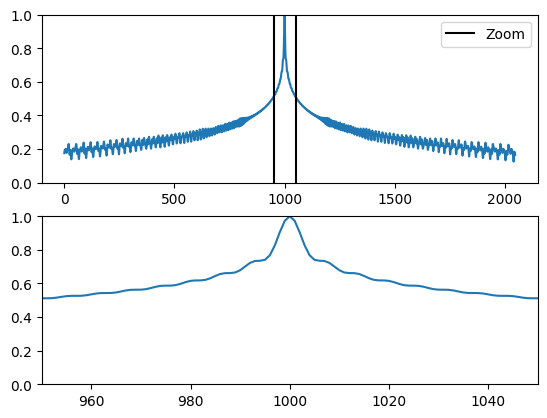

In [24]:
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

因此，使用这个来创建一个PositionEmbedding层，查找tokens的嵌入向量并添加位置向量:

In [25]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

【注意】：原始论文，对源语言和目标语言都使用了单个标记器和权重矩阵。本教程使用两个独立的标记器和权重矩阵。

In [26]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [27]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 80), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

#### 加&规范化
这些“加&规范”块分散在整个模型中。每个连接都连接一个残差连接，并通过LayerNormalization层运行结果。

组织代码的最简单方法是围绕这些残差的块。下面的部分将为每个层定义自定义层类。

残差的“Add & Norm”块被包括在内，这样训练是有效的。残差连接为梯度提供了一个直接的路径(并确保向量由注意层更新而不是替换)，而归一化为输出保持了一个合理的尺度。

#### 基础注意力层
注意层在整个模型中使用。除了如何配置注意力之外，这些都是相同的。每个都包含layers.MultiHeadAttention， layers.MultiHeadAttention和layers.Add。

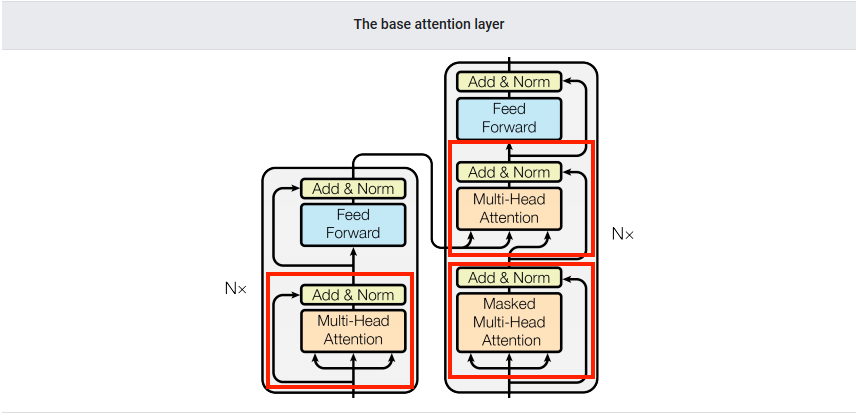

要实现这些注意力层，首先从一个简单的基类开始，它只包含组件层。每个用例将被实现为一个子类。以这种方式编写的代码要多一些，但目的很清楚。

In [28]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

##### 注意力回顾
在你进入每个用法的细节之前，这里有一个快速回顾一下注意力是如何工作的:
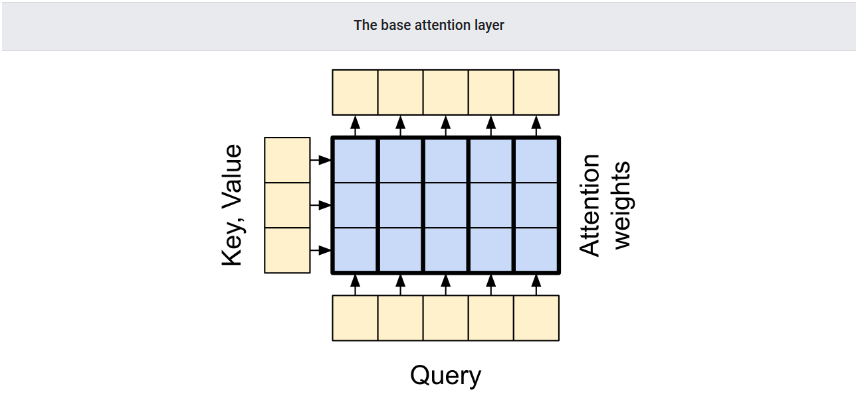

这有两个输入：
* 查询序列;被处理的序列;做注意力的顺序(下)。
* 上下文序列;正在处理的序列(左)。

输出具有与查询序列相同的形状

常见的比较是，此操作类似于字典查找。一个模糊的，可微的，矢量化的字典查找。

这是一个普通的python字典，在一个查询中传递了3个键和3个值。

In [29]:
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
print(result)

blue


* querys是你想要找到的
* keys是字典有什么样的信息
* value就是这些信息

当您在常规字典中查找查询时，字典会找到匹配的keys，并返回其关联value。查询要么有一个匹配的键，要么没有。您可以想象一个模糊字典，其中的键不必完全匹配。如果您在上面的字典中查找d["species"]，也许您希望它返回"pickup"，因为这是查询的最佳匹配。

注意层做这样的模糊查找，但它不仅仅是在寻找最好的键。它根据查询与每个keys的匹配程度组合这些值。

这是怎么做到的呢?在注意层中，查询、键和值都是向量。而不是做散列查找，注意力层结合查询和关键向量来确定它们的匹配程度，即“注意力得分”。该层返回所有值的平均值，由“注意力分数”加权。

查询序列的每个位置都提供了一个查询向量。上下文序列充当字典。在上下文序列中的每个位置提供一个键和值向量。输入向量不是直接使用的，layers.MultiHeadAttention层包括layers.Dense在使用输入向量之前对其进行投影。

#### 交叉注意层
Transformer的中心是交叉注意层。这一层连接编码器和解码器。这一层是模型中注意力最直接的使用，它执行的任务与NMT中的注意力块具有注意力教程相同。

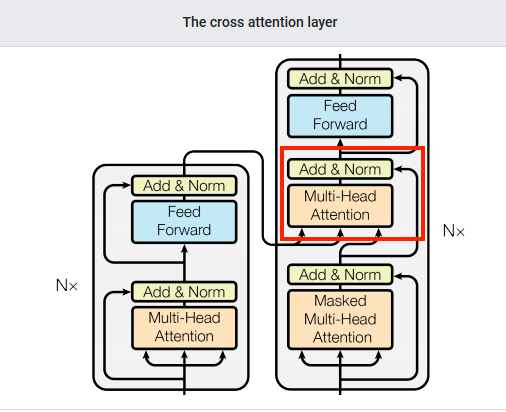

要实现这一点，在调用mha层（多头注意力层）时，将目标序列x作为查询传递，并将上下文序列作为键/值传递:

In [30]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # 把注意力分数存储起来，以便以后绘图
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

下面的漫画显示了信息是如何流经这一层的。列表示上下文序列的加权和。

为简单起见，没有显示剩余连接。

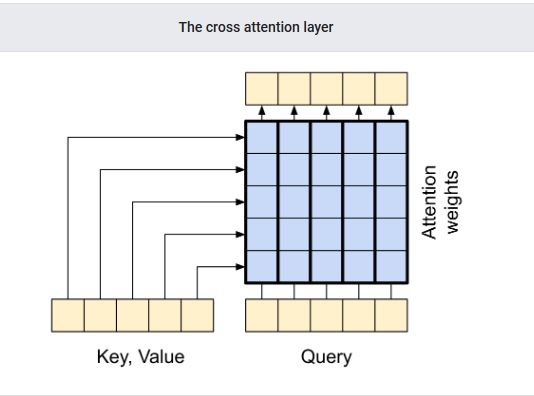

输出长度是查询序列的长度，而不是上下文键/值序列的长度。

图进一步简化如下。没有必要画出整个“注意力权重”矩阵。关键是每个查询位置都可以看到上下文中的所有键/值对，但是查询之间不交换信息。

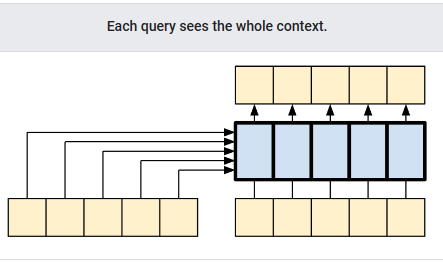

In [31]:
# 在样本输入上运行它:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape) # 键和值
print(en_emb.shape) # 查询
print(sample_ca(en_emb, pt_emb).shape)

(64, 85, 512)
(64, 80, 512)


InternalError: Exception encountered when calling layer "layer_normalization" "                 f"(type LayerNormalization).

{{function_node __wrapped__FusedBatchNormV3_device_/job:localhost/replica:0/task:0/device:GPU:0}} cuDNN launch failure : input shape ([1,5120,512,1]) [Op:FusedBatchNormV3]

Call arguments received by layer "layer_normalization" "                 f"(type LayerNormalization):
  • inputs=tf.Tensor(shape=(64, 80, 512), dtype=float32)

#### 全局自注意力层
这一层负责处理上下文序列，并沿着其长度传播信息:

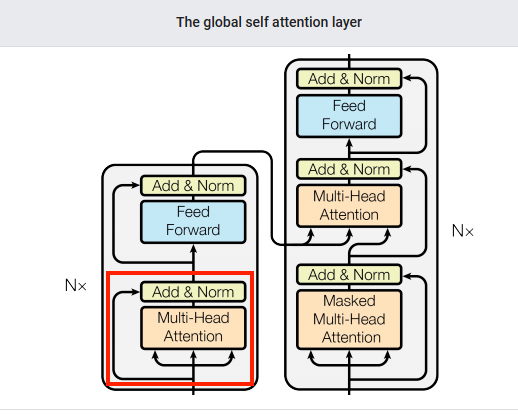

由于在生成翻译时上下文序列是固定的，因此允许信息在两个方向上流动。

在Transformer和自注意力之前，模型通常使用RNNs或CNNs来完成这项任务:

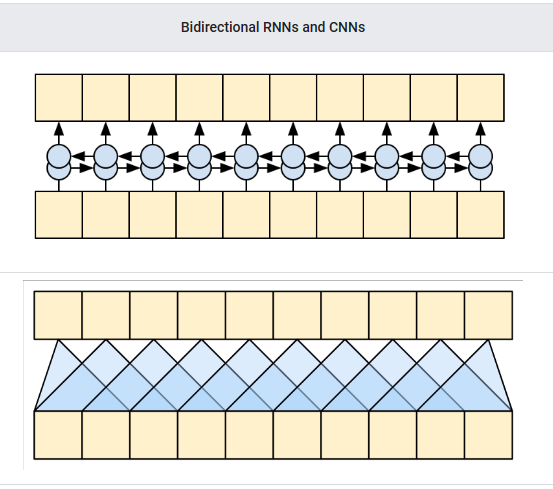

RNNs和cnn都有其局限性：
* RNN允许信息在整个序列中流动，但它要经过许多处理步骤才能到达那里(限制梯度流)。这些RNN步骤必须按顺序运行，因此RNN不太能够利用现代并行设备。

* 在CNN中，每个位置可以并行处理，但它只提供有限的接受域。接受域只随CNN层数线性增长，你需要堆叠一些卷积层来跨序列传输信息(Wavenet通过使用扩展卷积来减少这个问题)。

另一方面，全局自注意力层允许每个序列元素直接访问每个其他序列元素，只需进行少量操作，并且所有输出都可以并行计算。

要实现这一层，你只需要将目标序列x作为查询和值参数传递给mha层:

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape) # 查询和值的形状
print(sample_gsa(pt_emb).shape)

(64, 104, 512)


保持和之前一样的风格，你可以这样画:

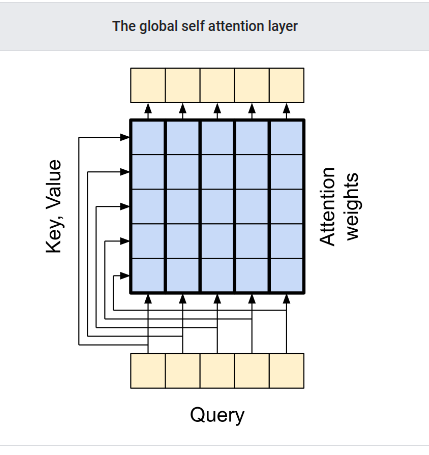

同样，为了清晰起见，省略了剩余连接。

这样画起来更紧凑，也更精确:

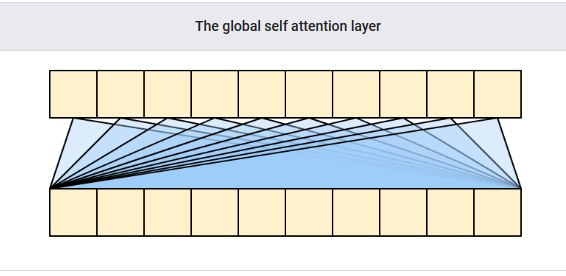



#### 因果自注意力层
对于输出序列，这一层做的工作与全局自关注层类似:

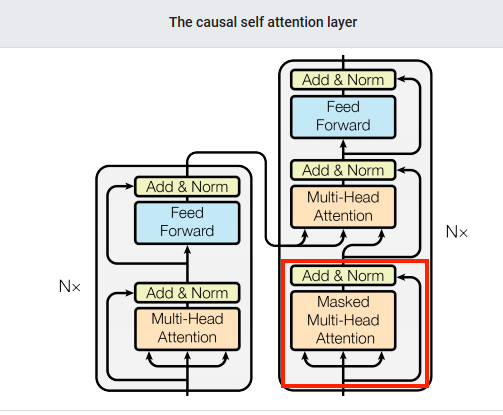

这需要与编码器的全局自注意力层处理方式不同。

就像文本生成教程和NMT的注意教程一样,Transformer是一个“自动回归”模型:它们在一段时间内生成文本一个标记,并将输出反馈给输入。为了使此有效,这些模型确保每个序列元素的输出只依赖于前面的序列元素;模型是“因果”的。

根据定义，单向RNN是因果关系。要制作因果卷积，你只需要填充输入并移动输出，使其正确对齐(使用layers.Conv1D(padding='causal'))。

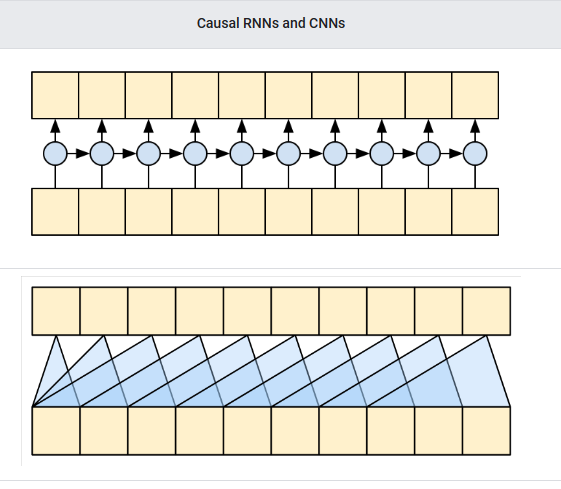

因果模型在这两个方面是有效的：
* 在训练中，它允许您计算输出序列中每个位置的损失，同时只执行一次模型。

* 在推理过程中，对于生成的每个新token，您只需要计算其输出，可以重用前一个序列元素的输出。
  * 对于RNN，你只需要RNN-state来解释之前的计算(将return_state=True传递给RNN层的构造函数)。
  * 对于CNN，你需要遵循Fast Wavenet的方法

为了构建因果自注意层，在计算注意分数和求和注意值时需要使用适当的掩码。

当你调用MultiHeadAttention层时，如果你将use_causal_mask = True传递给它，这是自动处理的:



In [ ]:
# 因果自注意力层
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

因果掩码确保每个位置只能访问在它之前的位置:

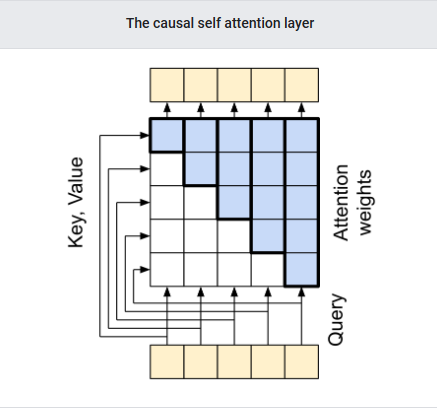

同样，为了简单起见，省略了剩余连接。

这一层的更紧凑的表示是:

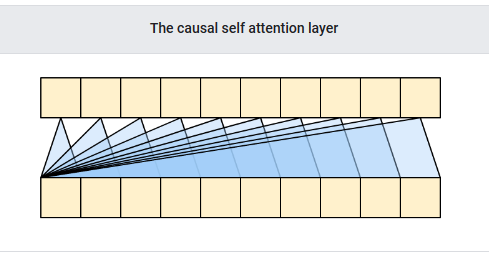

In [ ]:
# 测试图层:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 101, 512)


InternalError: Exception encountered when calling layer "layer_normalization_2" "                 f"(type LayerNormalization).

{{function_node __wrapped__FusedBatchNormV3_device_/job:localhost/replica:0/task:0/device:GPU:0}} cuDNN launch failure : input shape ([1,6464,512,1]) [Op:FusedBatchNormV3]

Call arguments received by layer "layer_normalization_2" "                 f"(type LayerNormalization):
  • inputs=tf.Tensor(shape=(64, 101, 512), dtype=float32)

早期序列元素的输出不依赖于后来的元素，所以在应用图层之前或之后修剪元素应该无关紧要:

In [ ]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

InternalError: Exception encountered when calling layer "layer_normalization_2" "                 f"(type LayerNormalization).

{{function_node __wrapped__FusedBatchNormV3_device_/job:localhost/replica:0/task:0/device:GPU:0}} cuDNN launch failure : input shape ([1,192,512,1]) [Op:FusedBatchNormV3]

Call arguments received by layer "layer_normalization_2" "                 f"(type LayerNormalization):
  • inputs=tf.Tensor(shape=(64, 3, 512), dtype=float32)

【注意】：当使用Keras掩码时，无效位置的输出值没有很好地定义。因此，上述内容可能不适用于遮罩区域。

#### 前馈神经网络
Transformer在编码器和解码器中也包括这种点向前馈网络:

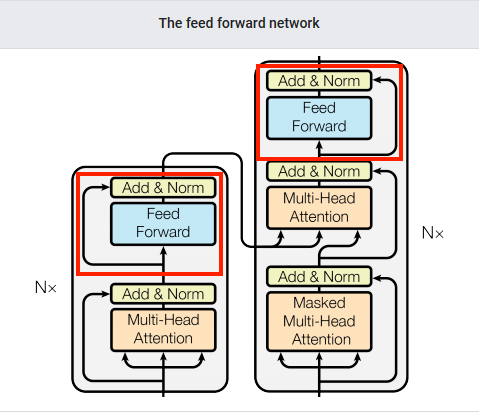

网络由两个线性层(tf.keras.layers.Dense)组成，中间有一个ReLU激活层和一个dropout层。与注意力层一样，这里的代码也包括剩余连接和规范化:

In [ ]:
# 前馈神经网络
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [ ]:
# 测试图层，输出与输入形状相同:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
#print(sample_ffn(en_emb).shape)

(64, 74, 512)
(64, 74, 512)


#### 编码器层
编码器包含N个编码器层的堆栈。其中每个EncoderLayer包含一个GlobalSelfAttention和FeedForward层:

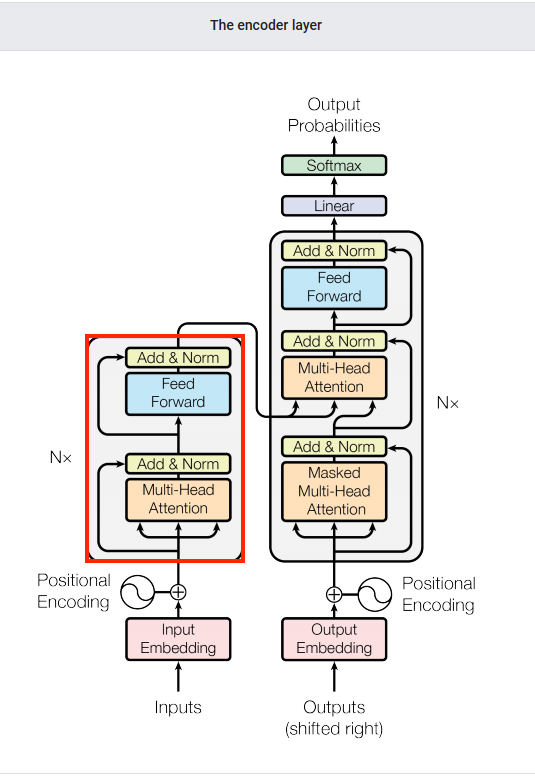

In [ ]:
# 下面是EncoderLayer的定义:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
# 快速测试一下，输出将具有与输入相同的形状:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
#print(sample_encoder_layer(pt_emb).shape)

(64, 85, 512)
(64, 85, 512)


#### 编码器
接下来构建编码器。

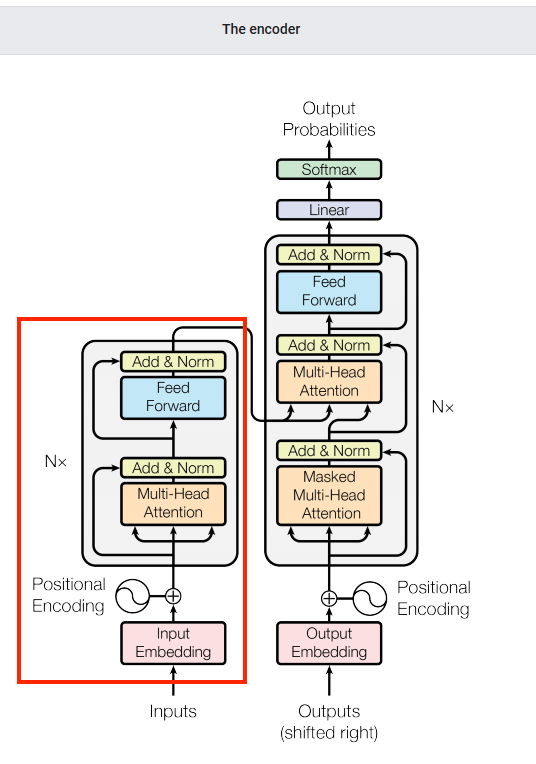

编码器包括:
* 一个PositionalEmbedding层在输入端。
* 一堆EncoderLayer层（编码器层）。

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` 是token-IDs的形状:(batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
# 测试一下编码器
# 实例化编码器
sample_encoder = Encoder(num_layers=4,
              d_model=512,
              num_heads=8,
              dff=2048,
              vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
#print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 85)
(64, 85, 512)


#### 解码器层
解码器的堆栈稍微复杂一些，每个解码器层包含一个CausalSelfAttention，一个CrossAttention和一个FeedForward层:

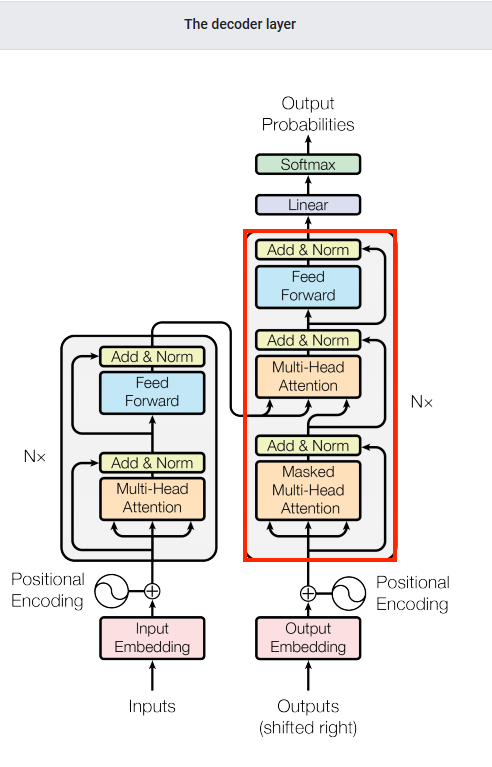

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
          *,
          d_model,
          num_heads,
          dff,
          dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # 缓存最后的注意力得分，以便稍后绘图
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
# 测试一下解码器层
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
#print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 74, 512)
(64, 85, 512)
(64, 74, 512)


#### 解码器
与编码器类似，解码器由位置嵌入和解码器层堆栈组成:

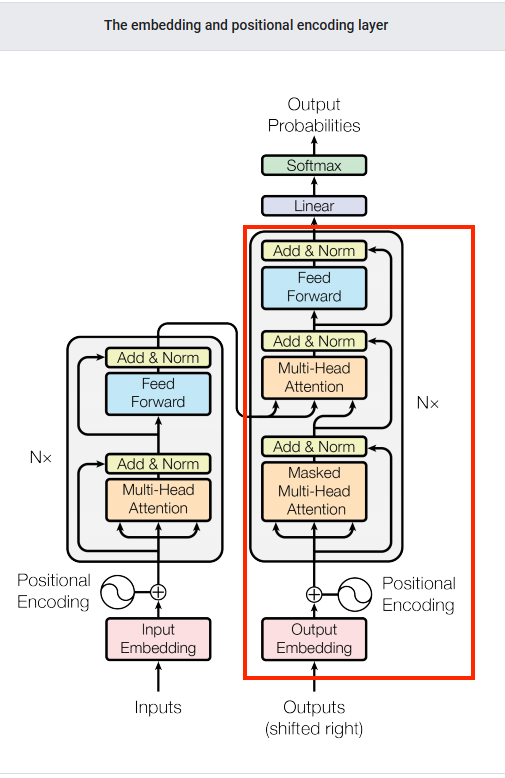

In [ ]:
# 定义解码器
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
# 测试解码器
# 实例化解码器
sample_decoder = Decoder(num_layers=4,
              d_model=512,
              num_heads=8,
              dff=2048,
              vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 74)
(64, 85, 512)
(64, 74, 512)


In [ ]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 74, 85])

创建了Transformer编码器和解码器之后，是时候构建Transformer模型并对其进行训练了。

### 构建Transformer模型
现在有编码器和解码器。要完成Transformer模型，需要将它们放在一起并添加一个最终的线性(Dense)层，该层将每个位置的结果向量转换为输出token概率。

解码器的输出是最后线性层的输入。

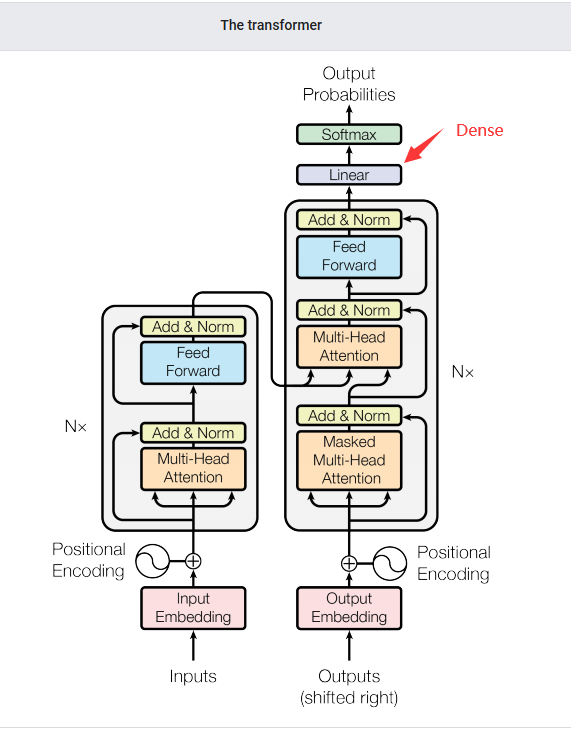

在编码器和解码器中都有一层的Transformer看起来几乎与RNN+注意力教程中的模型完全相同。多层Transformer有更多的层，但基本上是做同样的事情。

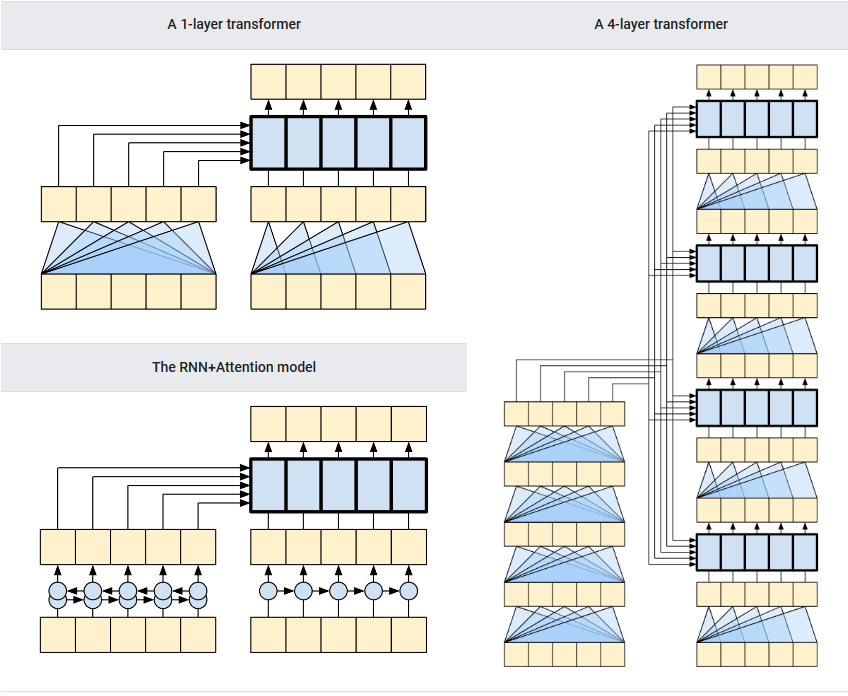

通过扩展tf.keras.Model来创建Transformer:

【注意】:原论文3.4节中，嵌入层与最终线性层之间的权值矩阵是共享的。为了简单起见，本教程使用两个单独的权重矩阵。

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
         input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                 num_heads=num_heads, dff=dff,
                 vocab_size=input_vocab_size,
                 dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                 num_heads=num_heads, dff=dff,
                 vocab_size=target_vocab_size,
                 dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # 使用Keras模型的“.fit"因此，您必须在第一个参数中传递所有输入.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # 最终的线性层输出
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # 删除keras掩码，这样它就不会缩放损失/指标
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # 返回最终输出和注意力权重
    return logits

#### 超参数
为了保持这个示例的小而相对快速，层的数量(num_layers)、嵌入的维数(d_model)和前馈层的内部维数(dff)都被减少了。

原始Transformer论文中描述的基本模型使用num_layers=6, d_model=512和dff=2048。

自注意力头的数量保持不变(num_heads=8)。



In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

#### 尝试
实例化Transformer模型:

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [ ]:
# 测试
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 74)
(64, 85)
(64, 74, 7010)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 74, 85)


In [ ]:
# 打印模型总结:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_38 (Dense)            multiple                  904290    
                                                                 
Total params: 10,184,162
Trainable params: 10,184,162
Non-trainable params: 0
_________________________________________________________________


### 训练
准备模型并开始训练它

#### 设置优化器
根据Transformer原始论文中的公式，使用带有自定义学习率调度器的Adam优化器。

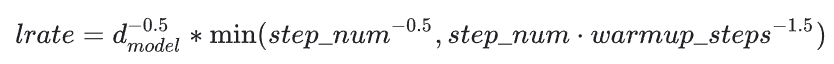

In [ ]:
# 自定义调度器
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
# 实例化优化器(在本例中为tf.keras.optimizers.Adam):
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                    epsilon=1e-9)

Text(0.5, 0, 'Train Step')

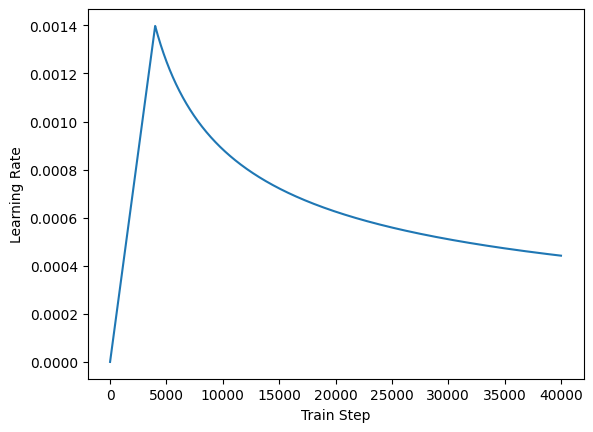

In [ ]:
# 测试自定义学习率调度器:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

#### 设置损失和指标
由于目标序列是填充的，所以在计算损失时应用填充掩码是很重要的。使用交叉熵损失函数(tf.keras.losses.SparseCategoricalCrossentropy):

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

#### 训练模型
准备好所有组件后，使用model.compile配置训练程序，然后使用model.fit运行它:

【注意】：大概需要20个小时左右

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# 查看
print(device_lib.list_local_devices())
# 调用GPU方法
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)
# 选择编号为0的GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"     # 我的笔记本只有一块GPU，编号是0，所以这里调用编号为0的GPU

transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)



NameError: name 'transformer' is not defined

### 运行推理
现在可以通过执行转换来测试模型。以下步骤用于推理:
* 使用葡萄牙语分词器(tokenizers.pt)编码输入句子。这是编码器输入。
* 解码器输入初始化为[START] token。
* 计算填充掩码和前瞻掩码。
* 然后，解码器通过查看编码器输出和它自己的输出(自注意力)来输出预测。
* 将预测的token连接到解码器输入并将其传递给下一个解码器。
* 在这种方法中，解码器根据它预测的前一个token来预测下一个token。



【注意】:该模型针对高效训练进行了优化，并同时对输出中的每个标记进行下一个标记预测。这在推理过程中是冗余的，并且只使用最后的预测。如果在推理模式(training=False)下运行时只计算最后一个预测，则该模型可以更有效地进行推理。


In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # 输入句子是葡萄牙语，因此添加了' [START] '和' [END] '标记。
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # 因为输出语言是英语，所以使用英语 `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` 需要TensorArray '(而不是Python列表)，以便可以通过' tf.function '跟踪动态循环。
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # 从' seq_len '维度中选择最后一个token
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # 将' predicted_id '连接到作为输入提供给解码器的输出。
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` 防止我们使用在循环的最后一次迭代中计算的attention_weights。
    # 所以，在循环外重新计算它们。
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

【注意】：注意:这个函数使用的是展开循环，而不是动态循环。它在每次调用时生成MAX_TOKENS。请参阅NMT with attention教程，了解带有动态循环的示例实现，它的效率要高得多。

创建一个Translator类的实例，并尝试几次:

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

例子1：

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

例子2：

In [ ]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

例子3：

In [ ]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

### 制作注意力平面图
在上一节中创建的Translator类返回一个注意力热图字典，您可以使用它来可视化模型的内部工作。

例如：

In [ ]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

创建一个函数，在生成token时绘制注意力:

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # 模型没有在输出中生成' <START> '。跳过它
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

这些是输入(葡萄牙语)token:

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

这些是输出(英语翻译)token:

In [ ]:
translated_tokens

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

这个模型可以处理不熟悉的单词。"triceratops"(三角龙)和"encyclopédia"(百科全书)都不在输入数据集中，即使没有共享词汇表，模型也会尝试将它们音译。例如:

In [ ]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

### 导出模型
已经测试了模型，并且推理是有效的。接下来，可以将其导出为tf.saved_model。要了解如何以SavedModel格式保存和加载模型，请使用本指南。

通过子类化tf创建一个名为ExportTranslator的类。带有 tf.function上 __call__方法:

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

在上面的tf.function只返回输出语句。由于在 tf.function中的非严格执行中任何不必要的值都不会被计算。

将translator封装在新创建的ExportTranslator中:

In [ ]:
translator = ExportTranslator(translator)

因为模型正在使用tf解码预测。Argmax的预测是确定的。原始模型和从其SavedModel中重新加载的模型应该给出相同的预测:

In [ ]:
translator('este é o primeiro livro que eu fiz.').numpy()

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

In [ ]:
reloaded = tf.saved_model.load('translator')

In [ ]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

### 结论
#### 缺点：
* 对于时间序列，时间步长的输出是根据整个历史计算的，而不仅仅是输入和当前隐藏状态。这可能效率较低。
* 如果输入具有时间/空间关系，如文本或图像，则必须添加一些位置编码，否则模型将有效地看到一袋单词。